In [58]:
#pip install num2words
#pip install nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from glob import glob
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import re
from typing import List, Generator
import sqlalchemy
import pandas as pd
from urllib import parse
import json
from tqdm import tqdm
import subprocess
import os

In [59]:
import sqlalchemy
import urllib.parse
import json

with open("conn_db.json", 'r') as f:
    db_conn = json.load(f)
db_password = urllib.parse.quote_plus(db_conn['PASS'])

engine = sqlalchemy.create_engine(f"mysql://{db_conn['USER']}:{db_password}@{db_conn['HOST']}:{db_conn['PORT']}/{db_conn['DB']}")

# with open(f"conn_db.json", "r", encoding='utf-8') as f:
#     keys = json.load(f)
# user = keys['user']
# password = keys['password']
# host = keys['host']
# port = keys['port']
# database = keys['database']
# password = parse.quote_plus(password)
# engine = sqlalchemy.create_engine(f"mysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")


In [60]:
def log(msg, flag=None):    
    if flag==None:
        flag = 0
    head = ["debug", "error", "status"]
    from time import gmtime, strftime
    now = strftime("%H:%M:%S", gmtime())
    if not os.path.isfile("./debug.log"):
        assert subprocess.call(f"echo \"[{now}][{head[flag]}] > {msg}\" > debug.log", shell=True)==0, print(f"[error] > shell command failed to execute")
    else: assert subprocess.call(f"echo \"[{now}][{head[flag]}] > {msg}\" >> debug.log", shell=True)==0, print(f"[error] > shell command failed to execute")
    


In [61]:
def generate_doc_from_db(engine: sqlalchemy.Engine, table_name: str, yield_size: int = 1000):
    query = f"SELECT * FROM {table_name} LIMIT 1000"
    with engine.connect() as conn:
        log("connection established")
        proxy = conn.execution_options(stream_results=True).execute(sqlalchemy.text(query))
        try:
            while 'batch not empty':
                batch = proxy.fetchmany(yield_size)
                if not batch:
                    break
                for row in batch:
                    yield row
        finally:
            log("disconnecting...")
            proxy.close()  # Ensure the result set is closed properly

In [62]:
# test 
def generate_doc():
    documents = ["""The standard 30-year fixed-rate mortgage averaged 6.94% in the week ending May 23, down from last week’s average of 7.02%, according to Freddie Mac data released Thursday. That’s the lowest level since early April and below the key 7% threshold.
After moving sideways throughout March, mortgage rates began to climb in late April as economic data showed that inflation’s cooldown stalled earlier in the year. Mortgage rates track the benchmark 10-year US Treasury yield, which moves in anticipation of the Federal Reserve’s decisions on interest rates. Stubbornly high inflation this year has dashed hopes that the Fed could cut interest rates in the spring or in the summer. But there’s finally been some good news on that front: The Consumer Price Index for April, released last week, showed that inflation didn’t pick up. Bond yields have mostly retreated this month.

“Spring homebuyers received an unexpected windfall this week, as mortgage rates fell below the seven percent threshold for the first time in over a month,” Sam Khater, Freddie Mac’s chief economist, said in a release.

Some Fed officials said earlier this week that they likely won’t raise interest rates again and a few have said they expect to cut rates this year. That bodes well for lower mortgage rates.

But for now, the housing market’s recovery is stagnant. Sales of previously owned homes, which make up the vast majority of the housing market, fell in April for the second month in a row, the National Association of Realtors reported Wednesday. That’s a stark contrast from earlier in the year when sales soared. """,
 """At least seven people have been killed and more than a dozen injured in a Russian missile attack on Kharkiv, north-eastern Ukraine, according to the regional head.
A further two people remain missing after the attack, which saw Russian forces strike Ukraine's second-largest city at least 15 times, Oleg Sinegubov said.
He advised people in the city to remain in shelters.
Ukraine's state railway company said several of its facilities had been damaged in the attack and a number of its employees had been injured.
Earlier this month, Russian forces began a renewed offensive in the region in an attempt to break through a weakened Ukrainian front line.
On Wednesday, Mr Sinegubov said fighting was continuing near the towns of Pletenivka and Vovchansk, but that Ukraine's forces were in control.
"This weakness is not ours, but the world's, which has not dared to deal with terrorists in the way they deserve for three years," he said in a post on X.
Ukrainian President Volodymyr Zelensky said the attacks on Kharkiv showed that Russia was taking advantage of Ukraine's lack of air defences.
Supplies of US-made surface-to-air missile systems were delayed by wrangling in Congress over a multi-billion dollar aid package for Ukraine which was only passed last month.
Mr Zelensky has repeatedly called for more air defence missiles and the supply of modern fighter jets from his allies.
Russia's glide bombs devastating Ukraine's cities on the cheap
Thousands flee Russian offensive in Kharkiv region
Ukraine's defence lines stretched as Russian troops advance
Fighting in the region has displaced around 14,000 people, according to the World Health Organization (WHO).
The estimated 189,000 people who remain near the border with Russia face “significant risks due to ongoing fighting”, WHO’s Jarno Habicht said.
Russia's President Vladimir Putin claims it is not his intention to capture Kharkiv, but that the aim was to create a "security zone" for Russia's border region.
Ukraine has been launching its own attacks into Russian territory.
Belgorod, located just 12km (7 miles) from the border with Ukraine, has been targeted a number of times, including earlier this week when a woman was killed and three others were injured as a result of a drone strike on a moving car.""",
"i want a dog.",
"I want you",
"what'up bro! you make me fill good."]
    yield from documents


In [63]:
def preprocessing(documents):
    stop_words = set(stopwords.words("english"))
    wordnet_lemmatizer = WordNetLemmatizer()
    iterate_counter = 0
    for text in tqdm(documents):
        log(f"iterate counter = {iterate_counter}")
        text = str(text).lower()
        tokens = word_tokenize(text)
        tokens = [i.replace(",", "") for i in tokens]
        tokens = [num2words(i) if i.isdigit() else i for i in tokens]
        adj_text = " ".join(tokens)
        adj_text = re.sub(r'^[^a-z]', ' ', adj_text)
        tokens = word_tokenize(adj_text)
        tokensWSW = [word for word in tokens if word not in stop_words]
        lemmatized_list = [wordnet_lemmatizer.lemmatize(word) for word in tokensWSW]
        clean_text = " ".join(lemmatized_list)
        iterate_counter += 1
        yield clean_text

In [64]:
def calculate_tfidf(documents_generator):
    log("calculating tf id matrix...")
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents_generator)
    return tfidf_matrix

In [65]:
def calculate_cosine_similarity(tfidf_matrix):
    log(f"calculating cosine similarity...")
    # 코사인 유사도 계산
    similarity_matrix = cosine_similarity(tfidf_matrix)
    log(f"cosine similarity calculated")
    return similarity_matrix

In [66]:
def clustering_model(similarity_matrix):
    log(f"clustering...")
    # 계층적 병합 클러스터링 수행
    clustering = linkage(similarity_matrix, method='ward')
    log(f"complete.")
    return clustering

In [74]:
documents_generator = generate_doc_from_db(engine, db_conn['table'])
preprocessing_documents =  preprocessing(documents_generator)
tfidf_matrix = calculate_tfidf(preprocessing_documents)
similarity_matrix = calculate_cosine_similarity(tfidf_matrix)
clustering = clustering_model(similarity_matrix)

1000it [00:16, 59.58it/s]


In [68]:
def plot_dendrogram(clustering, labels:None=None):
    plt.figure(figsize=(20, 15))
    dendrogram(clustering, labels=labels, orientation='right')
    plt.xlabel('Distance')
    plt.ylabel('Document')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()

In [80]:
clustering

array([[2.64000000e+02, 3.60000000e+02, 0.00000000e+00, 2.00000000e+00],
       [6.02000000e+02, 8.28000000e+02, 5.68115028e-02, 2.00000000e+00],
       [5.60000000e+02, 8.35000000e+02, 8.34554235e-02, 2.00000000e+00],
       ...,
       [1.92100000e+03, 1.99500000e+03, 6.30623476e+00, 5.87000000e+02],
       [1.99200000e+03, 1.99600000e+03, 7.29973387e+00, 9.13000000e+02],
       [1.99300000e+03, 1.99700000e+03, 8.97500474e+00, 1.00000000e+03]])

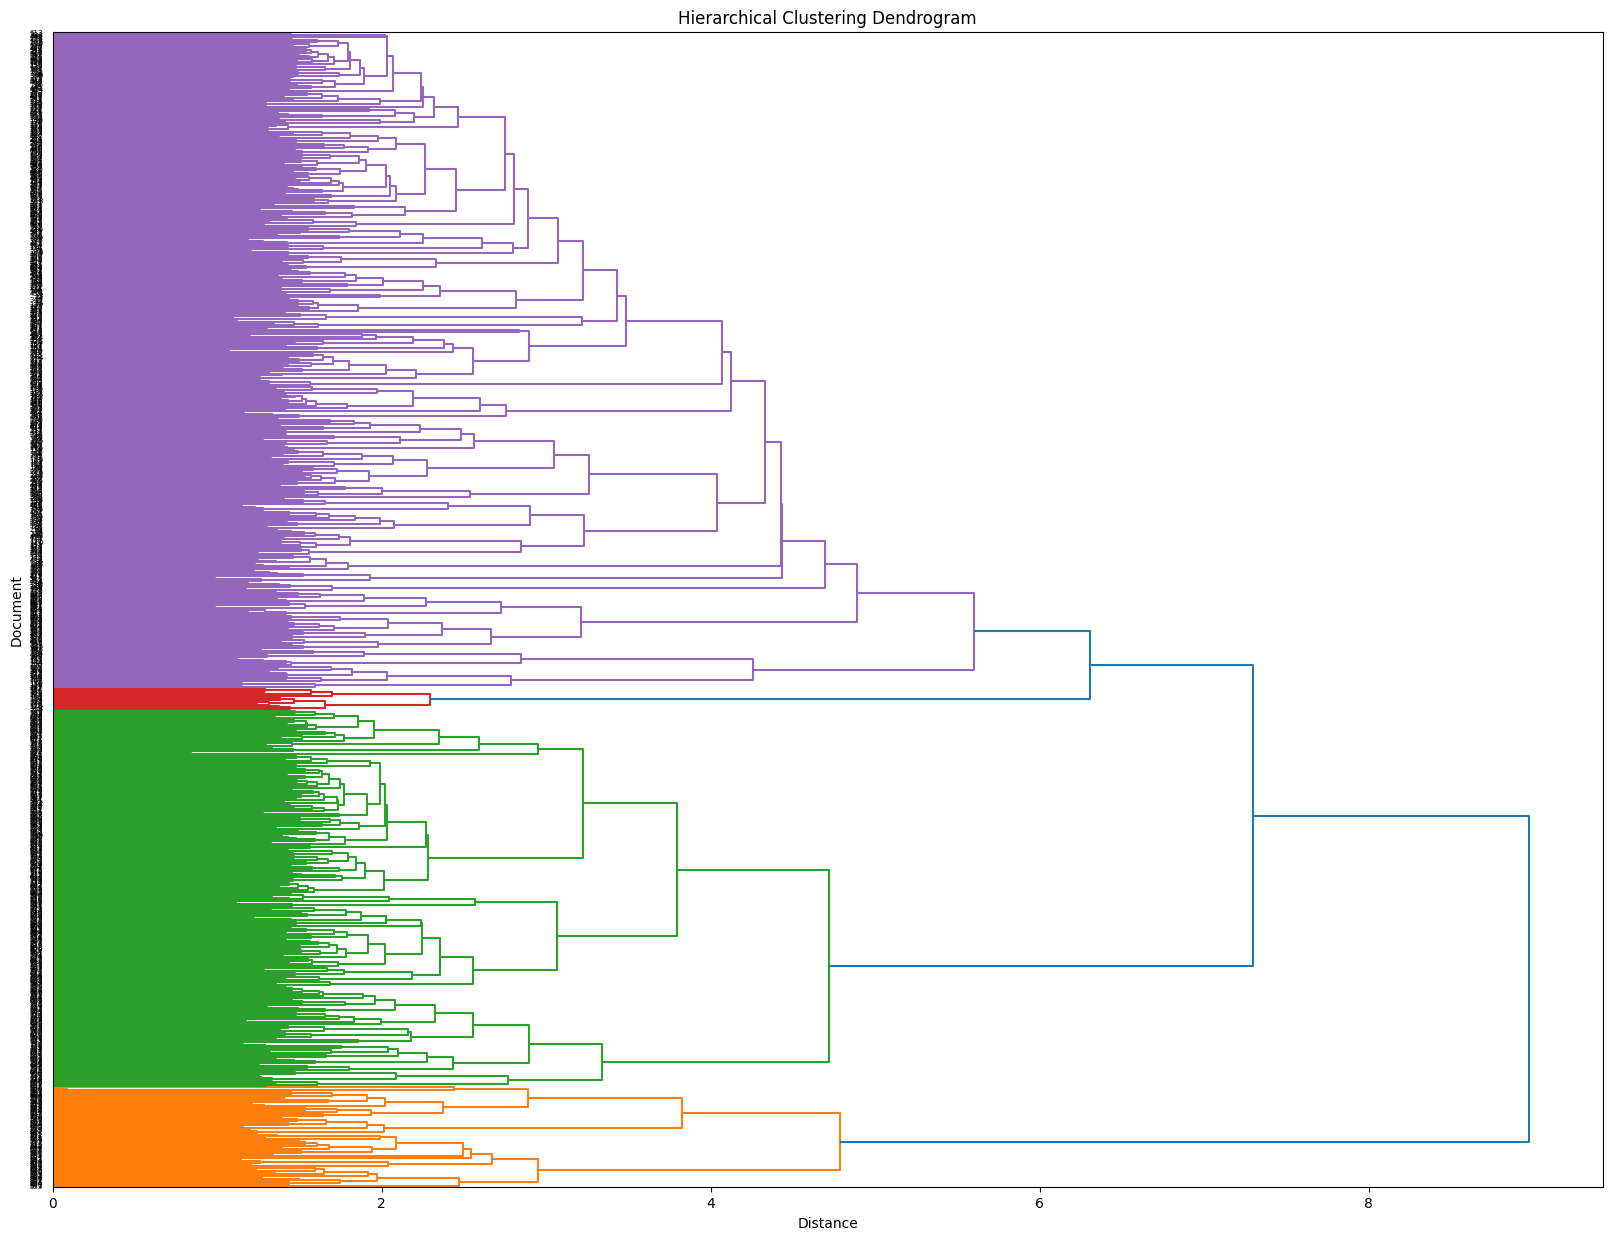

In [69]:
plot_dendrogram(clustering)

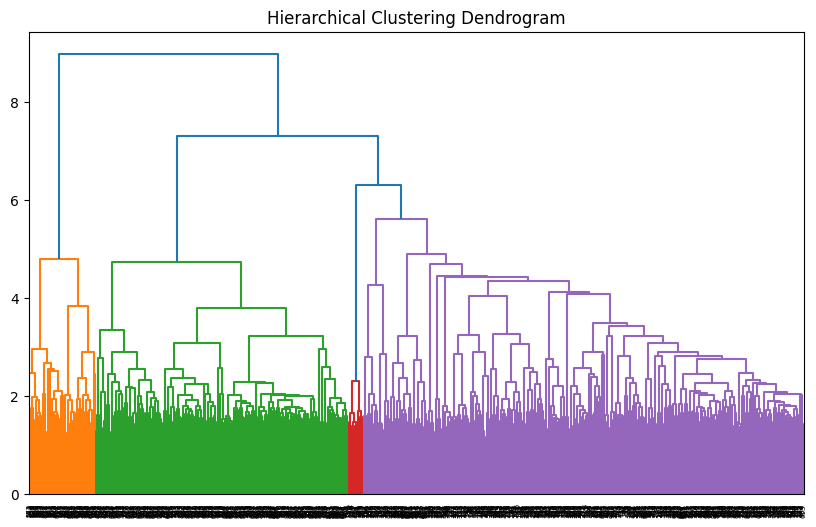

In [86]:

plt.figure(figsize=(10, 6))
dendrogram(clustering)
plt.title('Hierarchical Clustering Dendrogram')

plt.show()

In [91]:
cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
cluster_labels = cluster.fit_predict(similarity_matrix)

In [92]:
cluster_labels

array([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 3, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,

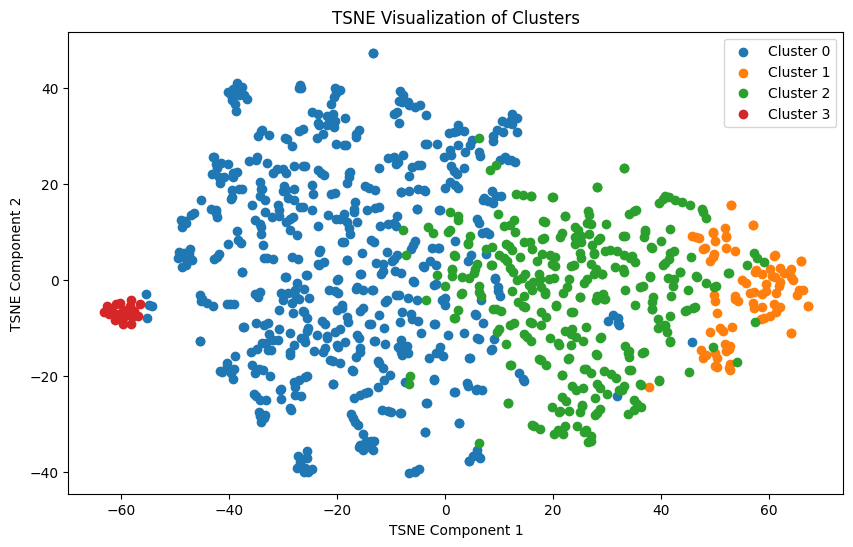

In [93]:
from sklearn.manifold import TSNE
import numpy as np

# TSNE를 사용하여 차원을 축소합니다.
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(similarity_matrix)

# 산점도를 그립니다.
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(tsne_result[cluster_labels == i, 0], tsne_result[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title('TSNE Visualization of Clusters')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.show()

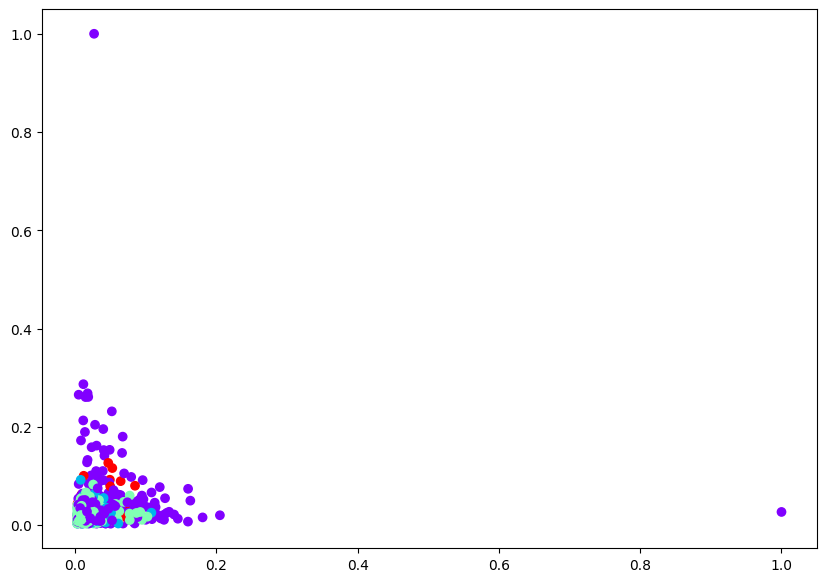

In [72]:
plt.figure(figsize=(10, 7))
plt.scatter(similarity_matrix[:,0], similarity_matrix[:,1], c=cluster.labels_, cmap='rainbow')

In [13]:
# merge_test